<a href="https://colab.research.google.com/github/rahiakela/deep-learning-with-python-francois-chollet/blob/3-getting-started-with-neural-networks/classifying_movie_reviews_binary_classification_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying movie reviews: a binary classification example

Two-class classification, or binary classification, may be the most widely applied kind of machine-learning problem. 

In this example, you’ll learn to classify movie reviews as positive or negative, based on the text content of the reviews.

## The IMDB dataset

You’ll work with the IMDB dataset: a set of 50,000 highly polarized reviews from the
Internet Movie Database. They’re split into 25,000 reviews for training and 25,000
reviews for testing, each set consisting of 50% negative and 50% positive reviews.

Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has
already been preprocessed: the reviews (sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Loading the IMDB dataset

In [0]:
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

The argument num_words=10000 means you’ll only keep the top 10,000 most frequently occurring words in the training data. Rare words will be discarded. This allows you to work with vector data of manageable size.

The variables train_data and test_data are lists of reviews; each review is a list of word indices (encoding a sequence of words). train_labels and test_labels are lists of 0s and 1s, where 0 stands for negative and 1 stands for positive:

In [20]:
train_data[:1]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])],
      dtype=object)

In [21]:
train_data.shape

(25000,)

In [22]:
train_labels[:5]

array([1, 0, 0, 1, 0])

In [23]:
# check total unique value
pd.Series(train_labels).unique()

array([1, 0])

In [24]:
pd.Series(train_labels).value_counts()

1    12500
0    12500
dtype: int64

In [25]:
train_labels.shape

(25000,)

Because you’re restricting yourself to the top 10,000 most frequent words, no word index will exceed 10,000:

In [26]:
max([max(sequence) for sequence in train_data])

9999

For kicks, here’s how you can quickly decode one of these reviews back to English words:

In [27]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## Preparing the data

You can’t feed lists of integers into a neural network. You have to turn your lists into tensors. There are two ways to do that:
* Pad your lists so that they all have the same length, turn them into an integer tensor of shape (samples, word_indices), and then use as the first layer in your network a layer capable of handling such integer tensors (the Embedding layer)
* One-hot encode your lists to turn them into vectors of 0s and 1s. This would
mean, for instance, turning the sequence [3, 5] into a 10,000-dimensional vector
that would be all 0s except for indices 3 and 5, which would be 1s. Then you
could use as the first layer in your network a Dense layer, capable of handling
floating-point vector data.

Let’s go with the latter solution to vectorize the data, which you’ll do manually for maximum clarity.

In [0]:
def vectorize_sequences(sequences, dimension=10000):
  # Create an all-zero matrix of shape (len(sequences), dimension)
  results = np.zeros((len(sequences), dimension))

  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1   # set specific indices of results[i] to 1s

  return  results 
# vectorized training data
x_train = vectorize_sequences(train_data)
# vectorized test data
x_test = vectorize_sequences(test_data)

Here's what our samples look like now:

In [29]:
x_train[:5]

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [30]:
x_test[:5]

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

We should also vectorize our labels, which is straightforward:

In [0]:
# vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [32]:
y_train[:5]

array([1., 0., 0., 1., 0.], dtype=float32)

## Building your network

The input data is vectors, and the labels are scalars (1s and 0s): this is the easiest setup
you’ll ever encounter. A type of network that performs well on such a problem is
a simple stack of fully connected (Dense) layers with relu activations: Dense(16,
activation='relu').

The argument being passed to each Dense layer (16) is the number of hidden
units of the layer. A hidden unit is a dimension in the representation space of the layer.

Having more hidden units (a higher-dimensional representation space)
allows your network to learn more-complex representations, but it makes the network
more computationally expensive and may lead to learning unwanted patterns (patterns
that will improve performance on the training data but not on the test data).

There are two key architecture decisions to be made about such a stack of Dense layers:
* How many layers to use
* How many hidden units to choose for each layer

The intermediate layers will use relu as their activation function, and the final layer
will use a sigmoid activation so as to output a probability (a score between 0 and 1,indicating how likely the sample is to have the target “1”: how likely the review is to be
positive). A relu (rectified linear unit) is a function meant to zero out negative values, 

<img src='https://github.com/rahiakela/img-repo/blob/master/deep-learning-with-python/relu-pic.JPG?raw=1' width='800'/>

whereas a sigmoid “squashes” arbitrary values into the [0, 1] interval, outputting something that can be interpreted as a probability.

<img src='https://github.com/rahiakela/img-repo/blob/master/deep-learning-with-python/sigmoid.JPG?raw=1' width='800'/>

what the network looks like. And here’s the Keras implementation,
similar to the MNIST example you saw previously.

<img src='https://github.com/rahiakela/img-repo/blob/master/deep-learning-with-python/three-layer-network.JPG?raw=1' width='400'/>


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 

In [0]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(10000, )))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Finally, you need to choose a loss function and an optimizer. Because you’re facing a
binary classification problem and the output of your network is a probability (you end
your network with a single-unit layer with a sigmoid activation), it’s best to use the binary_crossentropy loss. It isn’t the only viable choice: you could use, for instance,
mean_squared_error.

But crossentropy is usually the best choice when you’re dealing
with models that output probabilities. Crossentropy is a quantity from the field of Information
Theory that measures the distance between probability distributions or, in this
case, between the ground-truth distribution and your predictions.

Here’s the step where you configure the model with the rmsprop optimizer and
the binary_crossentropy loss function. Note that you’ll also monitor accuracy
during training.

In [0]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

Sometimes you may want to configure the parameters of your optimizer or pass a custom
loss function or metric function. The former can be done by passing an optimizer
class instance as the optimizer argument,the latter can be
done by passing function objects as the loss and/or metrics arguments.

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), 
              loss=tf.keras.losses.binary_crossentropy, 
              metrics=[tf.keras.metrics.binary_accuracy])

### Validating your approach

In order to monitor during training the accuracy of the model on data it has never
seen before, you’ll create a validation set by setting apart 10,000 samples from the
original training data.

In [0]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

You’ll now train the model for 20 epochs (20 iterations over all samples in the
x_train and y_train tensors), in mini-batches of 512 samples. At the same time,
you’ll monitor loss and accuracy on the 10,000 samples that you set apart. You do so by
passing the validation data as the validation_data argument.

#### Training your model

In [44]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 187us/sample - loss: 0.5350 - binary_accuracy: 0.7736 - val_loss: 0.4228 - val_binary_accuracy: 0.8499
Epoch 2/20
15000/15000 [==============================] - 2s 111us/sample - loss: 0.3258 - binary_accuracy: 0.9009 - val_loss: 0.3225 - val_binary_accuracy: 0.8808
Epoch 3/20
15000/15000 [==============================] - 2s 108us/sample - loss: 0.2408 - binary_accuracy: 0.9227 - val_loss: 0.2830 - val_binary_accuracy: 0.8925
Epoch 4/20
15000/15000 [==============================] - 2s 109us/sample - loss: 0.1895 - binary_accuracy: 0.9387 - val_loss: 0.2888 - val_binary_accuracy: 0.8851
Epoch 5/20
15000/15000 [==============================] - 2s 110us/sample - loss: 0.1554 - binary_accuracy: 0.9503 - val_loss: 0.2754 - val_binary_accuracy: 0.8901
Epoch 6/20
15000/15000 [==============================] - 2s 108us/sample - loss: 0.1304 - binary_accuracy: 0.9589 - val_loss: 0.2

Note that the call to model.fit() returns a History object. This object has a member
history, which is a dictionary containing data about everything that happened
during training. Let’s look at it:

In [45]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

#### Plotting the training and validation loss

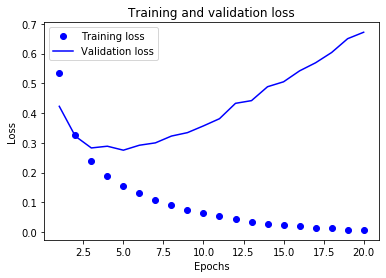

In [48]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

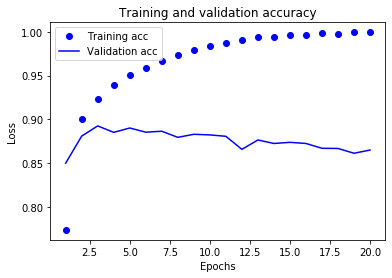

In [49]:
# clear figure
plt.clf()

acc_values = history.history['binary_accuracy']
val_acc_values = history.history['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

As you can see, the training loss decreases with every epoch, and the training accuracy
increases with every epoch. That’s what you would expect when running gradientdescent
optimization—the quantity you’re trying to minimize should be less with
every iteration. But that isn’t the case for the validation loss and accuracy: they seem to
peak at the fourth epoch.

This is an example of what we warned against earlier: 

a model that performs better on the training data isn’t necessarily a model that will do
better on data it has never seen before. In precise terms, what you’re seeing is overfitting:
after the second epoch, you’re overoptimizing on the training data, and you end
up learning representations that are specific to the training data and don’t generalize
to data outside of the training set.

#### Retraining a model from scratch

In [50]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(10000, )))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 181us/sample - loss: 0.5130 - accuracy: 0.7863 - val_loss: 0.4139 - val_accuracy: 0.8360
Epoch 2/20
15000/15000 [==============================] - 2s 110us/sample - loss: 0.3020 - accuracy: 0.9015 - val_loss: 0.3052 - val_accuracy: 0.8848
Epoch 3/20
15000/15000 [==============================] - 2s 107us/sample - loss: 0.2223 - accuracy: 0.9255 - val_loss: 0.2813 - val_accuracy: 0.8890
Epoch 4/20
15000/15000 [==============================] - 2s 107us/sample - loss: 0.1717 - accuracy: 0.9431 - val_loss: 0.2909 - val_accuracy: 0.8842
Epoch 5/20
15000/15000 [==============================] - 2s 108us/sample - loss: 0.1405 - accuracy: 0.9539 - val_loss: 0.2828 - val_accuracy: 0.8874
Epoch 6/20
15000/15000 [==============================] - 2s 106us/sample - loss: 0.1144 - accuracy: 0.9643 - val_loss: 0.3100 - val_accuracy: 0.8817
Epoch 7/20
15000/15000 [==========================

In [52]:
results = model.evaluate(x_test, y_test, verbose=0)
results

[0.7750125876784325, 0.8508]

This fairly naive approach achieves an accuracy of 88%. With state-of-the-art
approaches, you should be able to get close to 95%.

### Using a trained network to generate predictions on new data

After having trained a network, you’ll want to use it in a practical setting. You can generate
the likelihood of reviews being positive by using the predict method:

In [53]:
model.predict(x_test)

array([[0.00426176],
       [0.9999999 ],
       [0.99908733],
       ...,
       [0.0022164 ],
       [0.07409734],
       [0.9583351 ]], dtype=float32)

As you can see, the network is confident for some samples (0.99 or more, or 0.01 or
less) but less confident for others (0.6, 0.4).

## Further experiments

The following experiments will help convince you that the architecture choices you’ve
made are all fairly reasonable, although there’s still room for improvement:

### You used two hidden layers. Try using one or three hidden layers, and see how doing so affects validation and test accuracy.

In [63]:
model_1 = Sequential()
model_1.add(Dense(16, activation='relu', input_shape=(10000, )))
model_1.add(Dense(16, activation='relu'))
model_1.add(Dense(16, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

history_1 = model_1.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 168us/sample - loss: 0.5210 - accuracy: 0.7794 - val_loss: 0.3786 - val_accuracy: 0.8712
Epoch 2/20
15000/15000 [==============================] - 2s 125us/sample - loss: 0.3002 - accuracy: 0.9017 - val_loss: 0.3074 - val_accuracy: 0.8805
Epoch 3/20
15000/15000 [==============================] - 2s 124us/sample - loss: 0.2056 - accuracy: 0.9333 - val_loss: 0.2803 - val_accuracy: 0.8871
Epoch 4/20
15000/15000 [==============================] - 2s 124us/sample - loss: 0.1633 - accuracy: 0.9465 - val_loss: 0.2870 - val_accuracy: 0.8865
Epoch 5/20
15000/15000 [==============================] - 2s 123us/sample - loss: 0.1247 - accuracy: 0.9599 - val_loss: 0.4401 - val_accuracy: 0.8418
Epoch 6/20
15000/15000 [==============================] - 2s 123us/sample - loss: 0.1023 - accuracy: 0.9671 - val_loss: 0.3305 - val_accuracy: 0.8831
Epoch 7/20
15000/15000 [==========================

In [64]:
results = model_1.evaluate(x_test, y_test, verbose=0)
results

[0.9302626439237595, 0.84692]

In [68]:
history_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

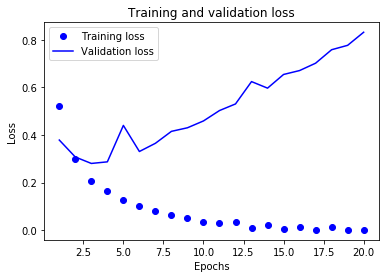

In [70]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss_values = history_1.history['loss']
val_loss_values = history_1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

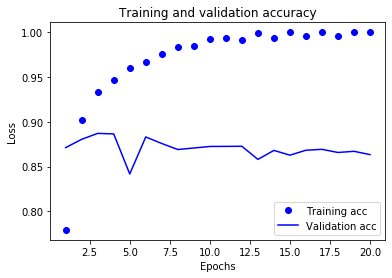

In [71]:
# clear figure
plt.clf()

acc_values = history_1.history['accuracy']
val_acc_values = history_1.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Try using layers with more hidden units or fewer hidden units: 32 units, 64 units, and so on.

In [72]:
model_2 = Sequential()
model_2.add(Dense(16, activation='relu', input_shape=(10000, )))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

model_2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

history_2 = model_2.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 219us/sample - loss: 0.5362 - accuracy: 0.7608 - val_loss: 0.3920 - val_accuracy: 0.8560
Epoch 2/20
15000/15000 [==============================] - 2s 123us/sample - loss: 0.2942 - accuracy: 0.9015 - val_loss: 0.3062 - val_accuracy: 0.8810
Epoch 3/20
15000/15000 [==============================] - 2s 127us/sample - loss: 0.2081 - accuracy: 0.9277 - val_loss: 0.2771 - val_accuracy: 0.8937
Epoch 4/20
15000/15000 [==============================] - 2s 128us/sample - loss: 0.1571 - accuracy: 0.9474 - val_loss: 0.3385 - val_accuracy: 0.8714
Epoch 5/20
15000/15000 [==============================] - 2s 132us/sample - loss: 0.1281 - accuracy: 0.9567 - val_loss: 0.3350 - val_accuracy: 0.8748
Epoch 6/20
15000/15000 [==============================] - 2s 128us/sample - loss: 0.0946 - accuracy: 0.9709 - val_loss: 0.3430 - val_accuracy: 0.8808
Epoch 7/20
15000/15000 [==========================

In [73]:
results = model_2.evaluate(x_test, y_test, verbose=0)
results

[0.9742084425234795, 0.85048]

In [74]:
history_2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

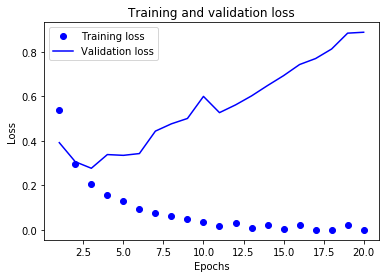

In [75]:
# clear figure
plt.clf()

acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss_values = history_2.history['loss']
val_loss_values = history_2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

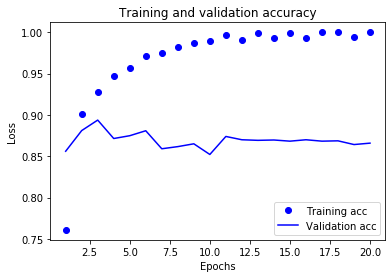

In [76]:
# clear figure
plt.clf()

acc_values = history_2.history['accuracy']
val_acc_values = history_2.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [77]:
model_3 = Sequential()
model_3.add(Dense(16, activation='relu', input_shape=(10000, )))
model_3.add(Dense(64, activation='relu'))
model_3.add(Dense(64, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

history_3 = model_3.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 195us/sample - loss: 0.5142 - accuracy: 0.7668 - val_loss: 0.3495 - val_accuracy: 0.8695
Epoch 2/20
15000/15000 [==============================] - 2s 135us/sample - loss: 0.2803 - accuracy: 0.8945 - val_loss: 0.2970 - val_accuracy: 0.8801
Epoch 3/20
15000/15000 [==============================] - 2s 131us/sample - loss: 0.2017 - accuracy: 0.9257 - val_loss: 0.2800 - val_accuracy: 0.8900
Epoch 4/20
15000/15000 [==============================] - 2s 129us/sample - loss: 0.1526 - accuracy: 0.9451 - val_loss: 0.2974 - val_accuracy: 0.8852
Epoch 5/20
15000/15000 [==============================] - 2s 130us/sample - loss: 0.1254 - accuracy: 0.9551 - val_loss: 0.3108 - val_accuracy: 0.8856
Epoch 6/20
15000/15000 [==============================] - 2s 133us/sample - loss: 0.0816 - accuracy: 0.9749 - val_loss: 0.3553 - val_accuracy: 0.8778
Epoch 7/20
15000/15000 [==========================

In [78]:
results = model_3.evaluate(x_test, y_test, verbose=0)
results

[1.0490596951705218, 0.85372]

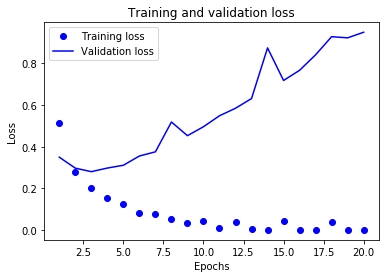

In [79]:
# clear figure
plt.clf()

acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
loss_values = history_3.history['loss']
val_loss_values = history_3.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

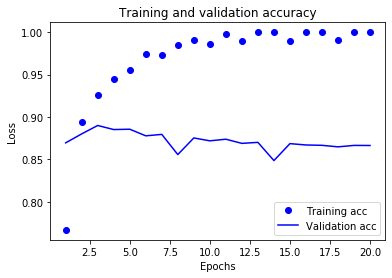

In [80]:
# clear figure
plt.clf()

acc_values = history_3.history['accuracy']
val_acc_values = history_3.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Try using the mse loss function instead of binary_crossentropy.

In [85]:
model_4 = Sequential()
model_4.add(Dense(16, activation='relu', input_shape=(10000, )))
model_4.add(Dense(16, activation='relu'))
model_4.add(Dense(16, activation='relu'))
model_4.add(Dense(1, activation='sigmoid'))

model_4.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])

history_4 = model_4.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 179us/sample - loss: 0.1823 - accuracy: 0.7599 - val_loss: 0.1232 - val_accuracy: 0.8691
Epoch 2/20
15000/15000 [==============================] - 2s 133us/sample - loss: 0.0918 - accuracy: 0.9017 - val_loss: 0.0945 - val_accuracy: 0.8807
Epoch 3/20
15000/15000 [==============================] - 2s 135us/sample - loss: 0.0619 - accuracy: 0.9315 - val_loss: 0.0856 - val_accuracy: 0.8870
Epoch 4/20
15000/15000 [==============================] - 2s 132us/sample - loss: 0.0479 - accuracy: 0.9470 - val_loss: 0.0865 - val_accuracy: 0.8806
Epoch 5/20
15000/15000 [==============================] - 2s 133us/sample - loss: 0.0398 - accuracy: 0.9564 - val_loss: 0.0831 - val_accuracy: 0.8882
Epoch 6/20
15000/15000 [==============================] - 2s 132us/sample - loss: 0.0301 - accuracy: 0.9694 - val_loss: 0.0902 - val_accuracy: 0.8794
Epoch 7/20
15000/15000 [==========================

In [86]:
results = model_4.evaluate(x_test, y_test, verbose=0)
results

[0.12333156722068786, 0.85376]

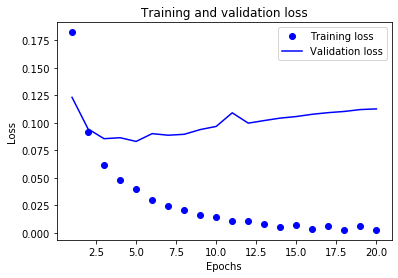

In [87]:
# clear figure
plt.clf()

acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']
loss_values = history_4.history['loss']
val_loss_values = history_4.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

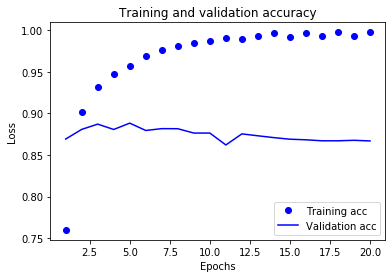

In [88]:
# clear figure
plt.clf()

acc_values = history_4.history['accuracy']
val_acc_values = history_4.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Try using the tanh activation (an activation that was popular in the early days of neural networks) instead of relu.

In [89]:
model_5 = Sequential()
model_5.add(Dense(16, activation='tanh', input_shape=(10000, )))
model_5.add(Dense(16, activation='tanh'))
model_5.add(Dense(16, activation='tanh'))
model_5.add(Dense(1, activation='sigmoid'))

model_5.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])

history_5 = model_5.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 172us/sample - loss: 0.1583 - accuracy: 0.7915 - val_loss: 0.1021 - val_accuracy: 0.8801
Epoch 2/20
15000/15000 [==============================] - 2s 129us/sample - loss: 0.0739 - accuracy: 0.9129 - val_loss: 0.0830 - val_accuracy: 0.8901
Epoch 3/20
15000/15000 [==============================] - 2s 130us/sample - loss: 0.0516 - accuracy: 0.9359 - val_loss: 0.0838 - val_accuracy: 0.8864
Epoch 4/20
15000/15000 [==============================] - 2s 126us/sample - loss: 0.0370 - accuracy: 0.9551 - val_loss: 0.1140 - val_accuracy: 0.8515
Epoch 5/20
15000/15000 [==============================] - 2s 128us/sample - loss: 0.0281 - accuracy: 0.9666 - val_loss: 0.0977 - val_accuracy: 0.8757
Epoch 6/20
15000/15000 [==============================] - 2s 130us/sample - loss: 0.0230 - accuracy: 0.9735 - val_loss: 0.1004 - val_accuracy: 0.8762
Epoch 7/20
15000/15000 [==========================

In [90]:
results = model_5.evaluate(x_test, y_test, verbose=0)
results

[0.13203691117152572, 0.85392]

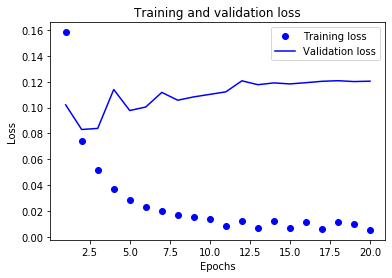

In [91]:
# clear figure
plt.clf()

acc = history_5.history['accuracy']
val_acc = history_5.history['val_accuracy']
loss_values = history_5.history['loss']
val_loss_values = history_5.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

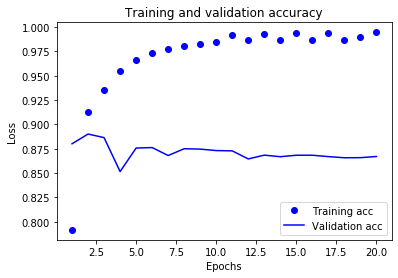

In [92]:
# clear figure
plt.clf()

acc_values = history_5.history['accuracy']
val_acc_values = history_5.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Wrapping up

Here’s what you should take away from this example:
* You usually need to do quite a bit of preprocessing on your raw data in order to
be able to feed it—as tensors—into a neural network. Sequences of words can
be encoded as binary vectors, but there are other encoding options, too.
* Stacks of Dense layers with relu activations can solve a wide range of problems
(including sentiment classification), and you’ll likely use them frequently.
* In a binary classification problem (two output classes), your network should
end with a Dense layer with one unit and a sigmoid activation: the output of
your network should be a scalar between 0 and 1, encoding a probability.
* With such a scalar sigmoid output on a binary classification problem, the loss
function you should use is binary_crossentropy.
* The rmsprop optimizer is generally a good enough choice, whatever your problem.
That’s one less thing for you to worry about.
* As they get better on their training data, neural networks eventually start overfitting
and end up obtaining increasingly worse results on data they’ve never
seen before. Be sure to always monitor performance on data that is outside of
the training set.
Licensed